# Measuring Cell Deformation

## Imports

In [1]:
%matplotlib widget

In [2]:
#@title Imports

import copy
import pickle

import cv2
import numpy as np
from stardist.models import StarDist2D
from skimage import io, color
import pandas as pd

import matplotlib.pyplot as plt

from scipy.spatial.distance import cdist

from ipywidgets import Button, HBox, interact, IntSlider, Output
from IPython.display import display, clear_output
import ipywidgets as widgets

from skimage.morphology import opening, disk, closing
from skimage.filters import gaussian
from skimage.color import label2rgb

import pandas as pd
from skimage.measure import regionprops, regionprops_table

from sklearn.decomposition import PCA


2024-06-11 15:21:12.310368: I external/local_tsl/tsl/cuda/cudart_stub.cc:32] Could not find cuda drivers on your machine, GPU will not be used.
2024-06-11 15:21:12.494098: I external/local_tsl/tsl/cuda/cudart_stub.cc:32] Could not find cuda drivers on your machine, GPU will not be used.
2024-06-11 15:21:13.136106: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-06-11 15:21:14.690213: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


## Loading Data
We can potentially load the `DataFrame`from a `.csv` file, like so

In [3]:
# Read the DataFrame from the CSV file
# filtered_df = pd.read_csv('filtered_df.csv')

but we'll just pickle the data to have types preserved through the saving and loading process. So we save the data by doing

In [4]:
# # Example dictionary
# data = {
#     1: [1, 2, 3],
#     2: [4, 5, 6],
#     3: [7, 8, 9]
# }

# # Save dictionary to a pickle file
# with open('data.pkl', 'wb') as pickle_file:
#     pickle.dump(data, pickle_file)


and then, we load it like

In [5]:
# Load dictionary from a pickle file
with open('data_tracking_oncostreams/data_7.pkl', 'rb') as pickle_file:
    filtered_df = pickle.load(pickle_file)

filtered_df

,frame,label,area,centroid-0,centroid-1,equivalent_diameter,bbox_area,convex_area,filled_area,major_axis_length,...,eccentricity,euler_number,extent,feret_diameter_max,max_intensity,mean_intensity,min_intensity,orientation,perimeter,solidity
0,155,218,362.0,768.146409,881.317680,21.468878,462.0,376.0,362.0,22.262421,...,0.361440,1,0.783550,23.409400,0.698970,0.568180,0.231162,1.294736,69.112698,0.962766
1,155,229,88.0,777.909091,891.977273,10.585135,120.0,93.0,88.0,13.385381,...,0.766940,1,0.733333,13.416408,0.522507,0.336352,0.196620,-0.557327,34.142136,0.946237
2,155,242,103.0,765.844660,864.310680,11.451798,130.0,110.0,103.0,13.701025,...,0.707738,1,0.792308,14.764823,0.395688,0.215725,0.125169,-1.309560,37.313708,0.936364
3,155,264,139.0,755.913669,894.043165,13.303394,208.0,152.0,139.0,15.307867,...,0.629534,1,0.668269,16.278821,0.566984,0.334814,0.170387,1.567675,44.627417,0.914474
4,156,97,514.0,762.535019,890.252918,25.582125,726.0,537.0,514.0,33.072962,...,0.787379,1,0.707989,34.481879,0.728158,0.508747,0.229004,-0.260862,88.669048,0.957169
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
63,204,43,545.0,934.163303,786.467890,26.342277,748.0,564.0,545.0,35.744849,...,0.836821,1,0.728610,36.769553,0.918121,0.702971,0.324894,1.207935,91.012193,0.966312
64,204,209,80.0,942.862500,807.637500,10.092530,120.0,89.0,80.0,11.700387,...,0.615145,1,0.666667,12.369317,0.492136,0.300175,0.176435,-1.417903,33.556349,0.898876
65,205,16,560.0,940.221429,804.837500,26.702325,875.0,590.0,560.0,39.081030,...,0.881332,1,0.640000,39.824616,0.942762,0.697202,0.298106,1.108179,97.254834,0.949153
66,206,47,634.0,945.892744,818.100946,28.411861,1026.0,660.0,634.0,40.476652,...,0.864528,1,0.617934,40.496913,0.876741,0.644460,0.231163,1.090452,101.982756,0.960606


## Data Analysis
We'll start by making a new dataframe with a row for each frame and a coords column that in the union of all coordinates in the objects of that frame, effectively merging the selected objects into one. Then, we should calculate:
- the area by frame;
- PCA (we could use the variance or min/max values over these directions to get the aspect ratio of the objects).

In [6]:
# Initialize an empty list to store the aggregated data
data = []

# Group filtered_df by 'frame' and aggregate coordinates
for frame, group in filtered_df.groupby('frame'):
    # Concatenate all coords lists for the current frame into a single list
    all_coords = [coord for sublist in group['coords'] for coord in sublist]
    
    # Append the aggregated data for the current frame to the data list
    data.append({'frame': frame, 'coords': all_coords})

# Create cell_df from the aggregated data
cell_df = pd.DataFrame(data)

# Display the first few rows of cell_df to verify
cell_df

,frame,coords
0,155,"[[758, 878], [758, 879], [758, 880], [758, 881..."
1,156,"[[746, 896], [746, 897], [747, 893], [747, 894..."
2,157,"[[743, 895], [743, 896], [743, 897], [744, 892..."
3,158,"[[735, 903], [735, 904], [735, 905], [735, 906..."
4,159,"[[738, 907], [738, 908], [738, 909], [739, 906..."
5,160,"[[742, 914], [742, 915], [742, 916], [743, 913..."
6,161,"[[740, 917], [740, 918], [741, 916], [741, 917..."
7,162,"[[747, 918], [747, 919], [748, 916], [748, 917..."
8,163,"[[753, 914], [753, 915], [753, 916], [753, 917..."
9,164,"[[757, 916], [757, 917], [757, 918], [758, 914..."


In [7]:
# Ensure cell_df['coords'] lists have more than one unique point for PCA
cell_df = cell_df[cell_df['coords'].map(lambda x: len(np.unique(x, axis=0)) > 1)]

# Add a new column for centroids in cell_df
cell_df['centroid'] = cell_df['coords'].apply(lambda coords: np.mean(coords, axis=0))

# Initialize lists to store the PCA results and variance information
pc1_list = []
pc2_list = []
variance_list = []
explained_variance_ratio_list = []

# Perform PCA on the coordinates for each frame
for coords in cell_df['coords']:
    pca = PCA(n_components=2)  # Initialize PCA to find the first two principal components
    pca.fit(coords)  # Fit the PCA model to the coordinates
    
    pc1, pc2 = pca.components_  # Get the principal components
    variance = pca.explained_variance_  # Variance of each PC
    explained_variance_ratio = pca.explained_variance_ratio_  # Percentage of variance explained by each PC
    
    pc1_list.append(pc1)
    pc2_list.append(pc2)
    variance_list.append(variance)
    explained_variance_ratio_list.append(explained_variance_ratio)

# Add the PCA results and variance information to the cell_df DataFrame
cell_df['pc1'] = pc1_list
cell_df['pc2'] = pc2_list
cell_df['variance'] = variance_list
cell_df['explained_variance_ratio'] = explained_variance_ratio_list

# Display the DataFrame to verify the results
cell_df

,frame,coords,centroid,pc1,pc2,variance,explained_variance_ratio
0,155,"[[758, 878], [758, 879], [758, 880], [758, 881...","[766.5881502890173, 882.6979768786127]","[0.18751135659892354, -0.982262434966558]","[0.982262434966558, 0.18751135659892354]","[111.7092898882648, 56.834125451822025]","[0.6627923711101846, 0.3372076288898154]"
1,156,"[[746, 896], [746, 897], [747, 893], [747, 894...","[758.6228209191759, 892.0063391442155]","[-0.9293853529129343, 0.3691109125871253]","[-0.3691109125871253, -0.9293853529129343]","[137.69721061508923, 23.836449737588513]","[0.8524366396109256, 0.14756336038907433]"
2,157,"[[743, 895], [743, 896], [743, 897], [744, 892...","[760.1463917525773, 893.9484536082474]","[0.985646467006511, 0.16882251650056238]","[0.16882251650056238, -0.985646467006511]","[77.15597942897855, 22.1421972771644]","[0.7770130528912864, 0.22298694710871364]"
3,158,"[[735, 903], [735, 904], [735, 905], [735, 906...","[749.3973214285714, 900.203125]","[0.9636003855562508, -0.26734677285474145]","[-0.26734677285474145, -0.9636003855562508]","[70.51693530950502, 18.941213260325604]","[0.7882673231769358, 0.21173267682306413]"
4,159,"[[738, 907], [738, 908], [738, 909], [739, 906...","[757.0435606060606, 902.6799242424242]","[-0.9688583033538708, 0.24761580729480623]","[-0.24761580729480623, -0.9688583033538708]","[97.07859074315239, 19.386125201876656]","[0.8335450780558565, 0.16645492194414352]"
5,160,"[[742, 914], [742, 915], [742, 916], [743, 913...","[761.0767590618337, 910.9232409381663]","[-0.9781225437860629, 0.20802953957907394]","[-0.20802953957907394, -0.9781225437860629]","[95.50702056580516, 15.023905390493926]","[0.8640750969874805, 0.1359249030125195]"
6,161,"[[740, 917], [740, 918], [741, 916], [741, 917...","[758.4285714285714, 914.4261083743843]","[-0.98335634874194, 0.18168734515348045]","[-0.18168734515348045, -0.98335634874194]","[88.23853021054747, 12.00520268490957]","[0.8802398679882596, 0.11976013201174031]"
7,162,"[[747, 918], [747, 919], [748, 916], [748, 917...","[768.3511111111111, 915.3911111111111]","[-0.9972776678064725, 0.07373773317971417]","[-0.07373773317971417, -0.9972776678064725]","[116.86950696864808, 11.236704365180154]","[0.9122860300981132, 0.08771396990188675]"
8,163,"[[753, 914], [753, 915], [753, 916], [753, 917...","[775.1186813186813, 914.7736263736264]","[0.9999784742344643, -0.006561331245481966]","[-0.006561331245481966, -0.9999784742344643]","[150.79366932135338, 10.878741967797959]","[0.9327112035934114, 0.06728879640658858]"
9,164,"[[757, 916], [757, 917], [757, 918], [758, 914...","[772.9437869822485, 914.4349112426036]","[0.9915856058212319, -0.12945264125594416]","[-0.12945264125594416, -0.9915856058212319]","[69.2622164595107, 10.574578792714801]","[0.8675475542410374, 0.13245244575896262]"


In [8]:
cell_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 53 entries, 0 to 52
Data columns (total 7 columns):
 #   Column                    Non-Null Count  Dtype 
---  ------                    --------------  ----- 
 0   frame                     53 non-null     int64 
 1   coords                    53 non-null     object
 2   centroid                  53 non-null     object
 3   pc1                       53 non-null     object
 4   pc2                       53 non-null     object
 5   variance                  53 non-null     object
 6   explained_variance_ratio  53 non-null     object
dtypes: int64(1), object(6)
memory usage: 3.0+ KB


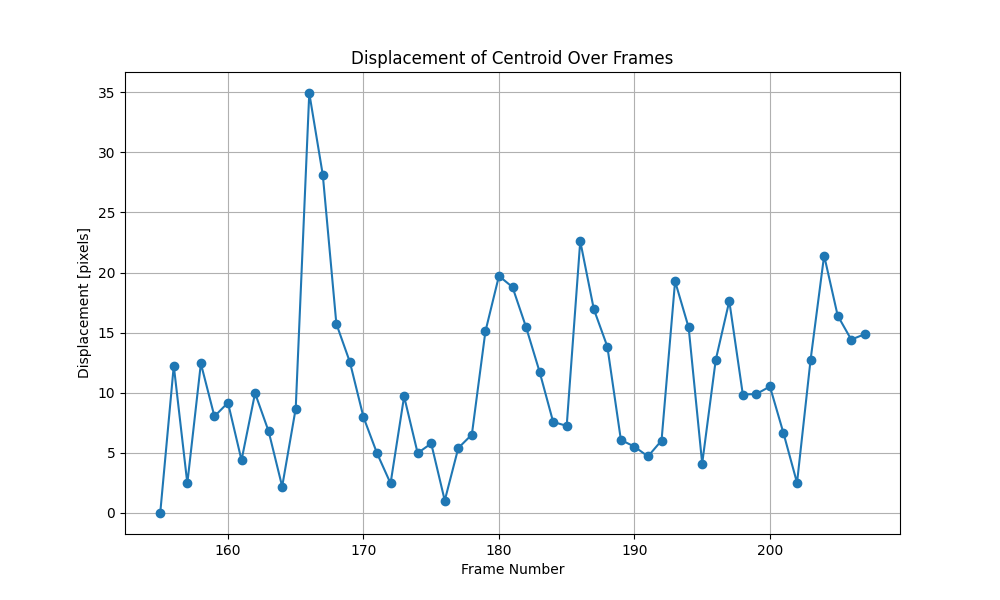

In [9]:
# Let's plot the displacement to give an idea of speed

# Calculate displacements
displacements = [0]  # The displacement for the first frame is 0 by definition
for i in range(1, len(cell_df)):
    # Calculate the Euclidean distance between consecutive centroids
    displacement = np.linalg.norm(cell_df['centroid'].iloc[i] - cell_df['centroid'].iloc[i-1])
    displacements.append(displacement)

# Add the displacements to the cell_df DataFrame
cell_df['displacement'] = displacements

# Plotting
plt.figure(figsize=(10, 6))
plt.plot(cell_df['frame'], cell_df['displacement'], marker='o', linestyle='-')
plt.title('Displacement of Centroid Over Frames')
plt.xlabel('Frame Number')
plt.ylabel('Displacement [pixels]')
plt.grid(True)
plt.show()


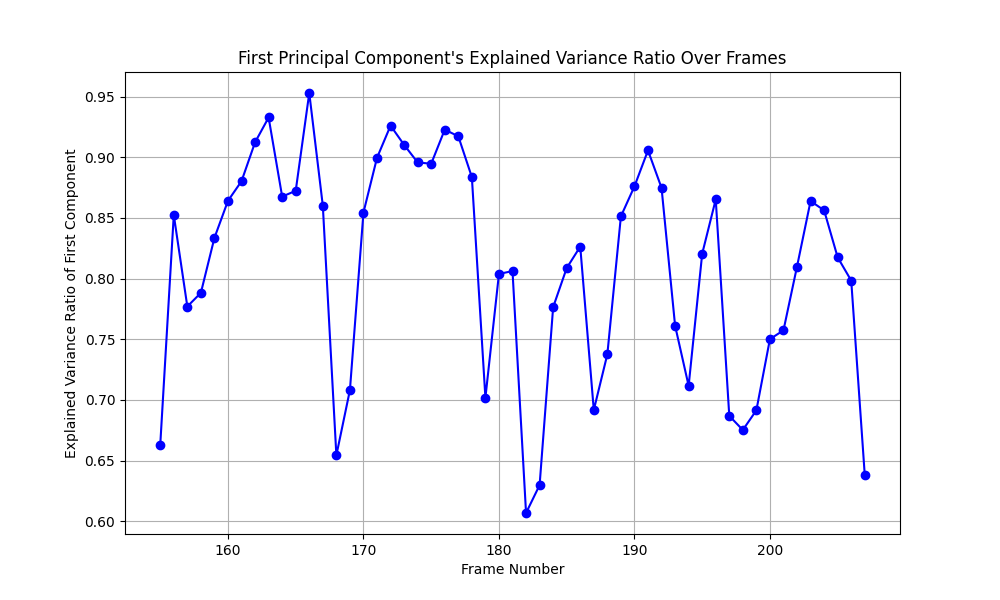

In [10]:
# Extract the first component of the explained_variance_ratio for each frame
# to give an idea of cell deformation

first_component_variance_ratio = [ratio[0] for ratio in cell_df['explained_variance_ratio']]

# Plotting
plt.figure(figsize=(10, 6))
plt.plot(cell_df['frame'], first_component_variance_ratio, marker='o', linestyle='-', color='blue')
plt.title('First Principal Component\'s Explained Variance Ratio Over Frames')
plt.xlabel('Frame Number')
plt.ylabel('Explained Variance Ratio of First Component')
plt.grid(True)
plt.show()


## Displacement Curve Characterization
Characterizing the displacement curve of the cell centroid can provide insightful information about the cell's movement patterns, so let's try several methods to analyze this curve.

### 1. Fourier Analysis
Fourier analysis allows you to decompose the displacement signal into its frequency components. This can help identify periodic behaviors or oscillations in the cell's movement.


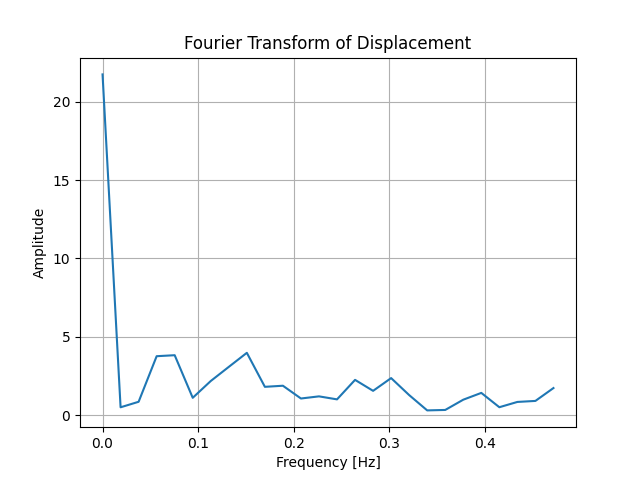

In [11]:
from scipy.fft import fft, fftfreq

# Assume `displacement` is your displacement array and `frame_numbers` is the array of frame numbers
displacement = cell_df['displacement'].values
frame_numbers = cell_df['frame'].values

# Number of sample points
N = len(displacement)

# Sample spacing: should be the inverse of the frame rate
# for units to be correct
T = 1 # (frame_numbers[-1] - frame_numbers[0]) / N

# Fourier Transform
yf = fft(displacement)
xf = fftfreq(N, T)[:N//2]

# Plot the FFT result
plt.figure()
plt.plot(xf, 2.0/N * np.abs(yf[:N//2]))
plt.title("Fourier Transform of Displacement")
plt.xlabel("Frequency [Hz]")
plt.ylabel("Amplitude")
plt.grid()
plt.show()


### 2. Autocorrelation
Autocorrelation can help determine how the displacement is correlated with itself at different time lags, indicating periodicity or repeating patterns. The autocorrelation at lag 0 is always 1, as the signal is perfectly correlated with itself. Autocorrelation with positive lage measures the correlation between the signal and a shifted version of itself by the specified number of frames. High autocorrelation at a certain lag suggests periodicity or repeating patterns with that period.


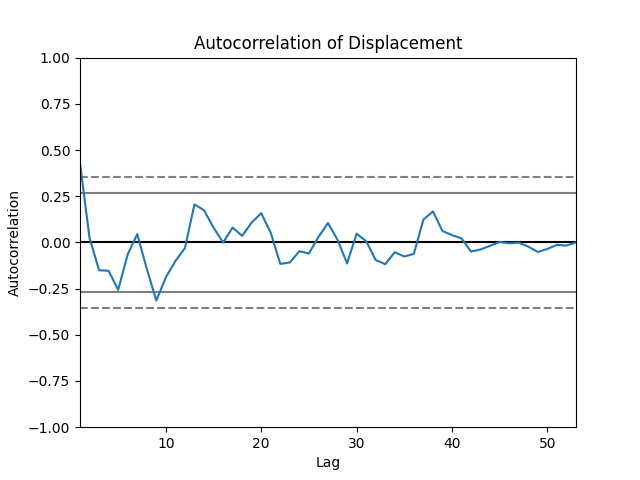

In [12]:
# Compute the autocorrelation
autocorr = pd.Series(displacement).autocorr(lag=1)

# Plot the autocorrelation
plt.figure()
pd.plotting.autocorrelation_plot(pd.Series(displacement))
plt.title("Autocorrelation of Displacement")
plt.xlabel("Lag")
plt.ylabel("Autocorrelation")
plt.grid()
plt.show()

### 3. Spectral Density Estimation
Spectral density estimation can provide insights into the distribution of power across different frequency components of the displacement signal. In this context, power refers to the magnitude of the signal's frequency components. Higher power at a certain frequency indicates that the signal has significant variation (or energy) at that frequency. Therefore, the Power Spectral Density (PSD) function shows the distribution of power across various frequencies. Peaks in the PSD indicate dominant periodic components in the signal. E.g., if the PSD has a peak at 0.1 Hz, it suggests that there is a strong periodic component in the displacement signal with a frequency of 0.1 Hz, or a period of 10 frames. I'd be 10 seconds if we had seconds as the time unit. We can make that conversion by checking the FPS of the video.


_spectral_py.py (589): nperseg = 256 is greater than input length  = 53, using nperseg = 53


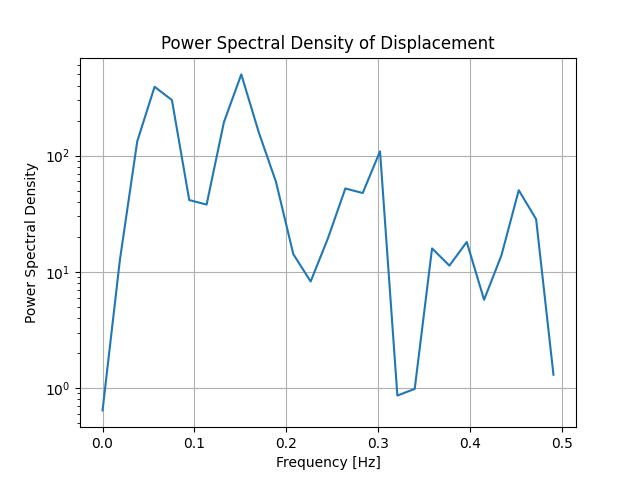

In [13]:
from scipy.signal import welch

# Calculate the power spectral density
frequencies, psd = welch(displacement, fs=1.0/T)

# Plot the power spectral density
plt.figure()
plt.semilogy(frequencies, psd)
plt.title("Power Spectral Density of Displacement")
plt.xlabel("Frequency [Hz]")
plt.ylabel("Power Spectral Density")
plt.grid()
plt.show()

### 4. Moving Average and Smoothing
Applying a moving average or other smoothing techniques can help to observe the trend and reduce noise in the displacement curve. A moving average is a method used to smooth out short-term fluctuations and highlight longer-term trends in time series data. It involves averaging a fixed number of consecutive data points (defined by the window size) as the window slides across the data. For each position in the data series, you take the average of the current point and the surrounding points within the window. This averaged value replaces the central point in the window.


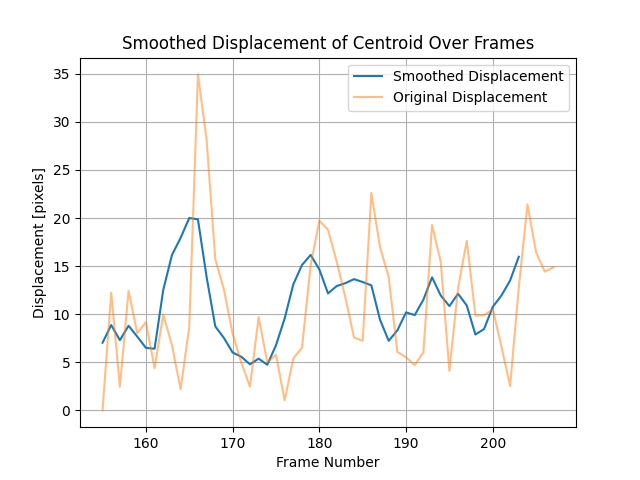

In [14]:
window_size = 5  # Set the window size for the moving average

# Calculate the moving average
displacement_smooth = np.convolve(displacement, np.ones(window_size)/window_size, mode='valid')

# Plot the smoothed displacement curve
plt.figure()
plt.plot(frame_numbers[:len(displacement_smooth)], displacement_smooth, label='Smoothed Displacement')
plt.plot(frame_numbers, displacement, alpha=0.5, label='Original Displacement')
plt.title("Smoothed Displacement of Centroid Over Frames")
plt.xlabel("Frame Number")
plt.ylabel("Displacement [pixels]")
plt.legend()
plt.grid()
plt.show()

### 5. Statistical Analysis
Basic statistical analysis such as calculating the mean, standard deviation, and identifying peaks can provide additional characteristics of the displacement curve. It's not very interesting to do this directly on the displacement curve, but this example should enable you to explore things like identifying peaks in the PSD, or even in the PSD of a moving averaged version of the curve.


Mean Displacement: 10.87707734416056
Standard Deviation: 6.894906034099712
Number of Peaks: 13


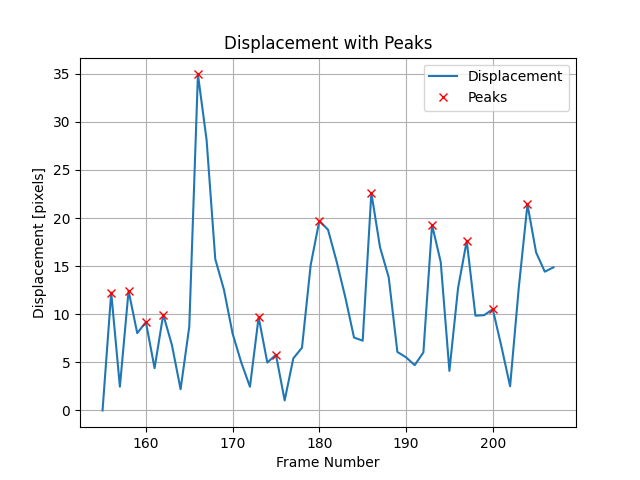

In [15]:
from scipy.signal import find_peaks

# Calculate basic statistics
mean_displacement = np.mean(displacement)
std_displacement = np.std(displacement)
peaks, _ = find_peaks(displacement)

# Print statistics
print(f"Mean Displacement: {mean_displacement}")
print(f"Standard Deviation: {std_displacement}")
print(f"Number of Peaks: {len(peaks)}")

# Plot displacement with peaks
plt.figure()
plt.plot(frame_numbers, displacement, label='Displacement')
plt.plot(frame_numbers[peaks], displacement[peaks], 'rx', label='Peaks')
plt.title("Displacement with Peaks")
plt.xlabel("Frame Number")
plt.ylabel("Displacement [pixels]")
plt.legend()
plt.grid()
plt.show()

## Eccentricity Curve Characterization

## Displacement vs Eccentricity

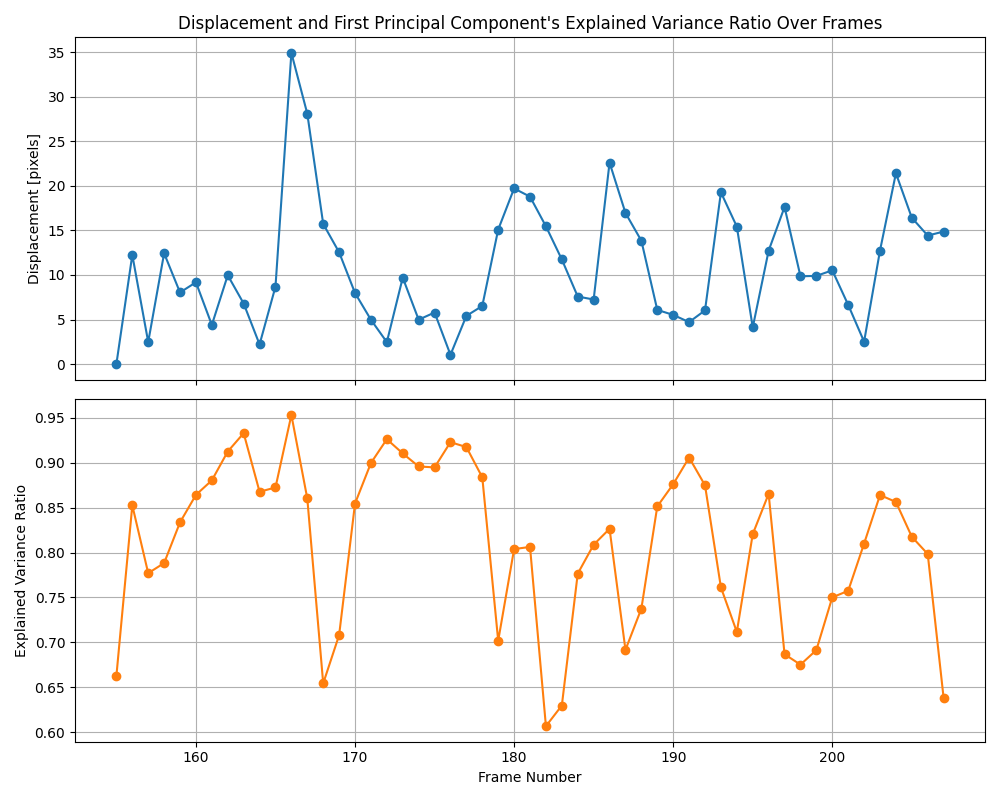

In [18]:
# Create subplots
fig, (ax1, ax2) = plt.subplots(2, 1, sharex=True, figsize=(10, 8))

# Plot Displacement
ax1.plot(cell_df['frame'], cell_df['displacement'], marker='o', linestyle='-', color='tab:blue')
ax1.set_title('Displacement and First Principal Component\'s Explained Variance Ratio Over Frames')
ax1.set_ylabel('Displacement [pixels]')
ax1.grid(True)

# Plot First Principal Component's Explained Variance Ratio
ax2.plot(cell_df['frame'], first_component_variance_ratio, marker='o', linestyle='-', color='tab:orange')
ax2.set_xlabel('Frame Number')
ax2.set_ylabel('Explained Variance Ratio')
ax2.grid(True)

# Adjust layout to prevent overlap
plt.tight_layout()
plt.show()

Note how peaks and stable zones roughly coincide, and how a peak in excentricity seems to precede a peak in displacement. 

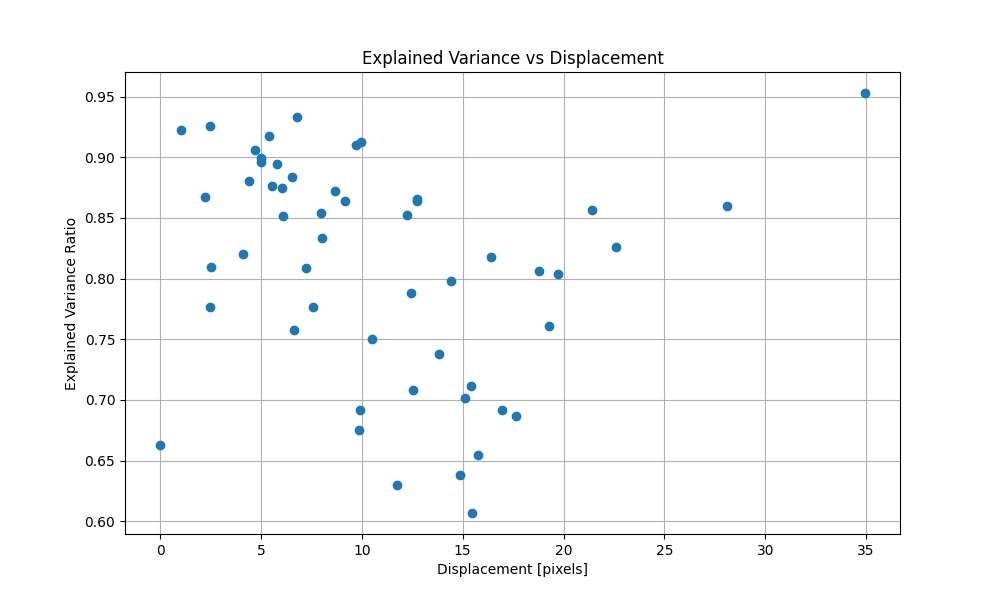

In [23]:
# “Trajectory”
plt.figure(figsize=(10, 6))
plt.plot(cell_df['displacement'], first_component_variance_ratio, marker='o', linestyle='')
# linestyle='-', cell_df['frame'] # hue?
plt.title('Explained Variance vs Displacement')
plt.xlabel('Displacement [pixels]')
plt.ylabel('Explained Variance Ratio')
plt.grid(True)
plt.show()

Note how, except for the extreme values in displacement, there seems to be a negative correlation between the explained variance and the displacement.

### Cross-correlation
Cross-correlation can help identify any lagged relationship between the two time series. It measures the similarity between two signals as a function of the time-lag applied to one of them.

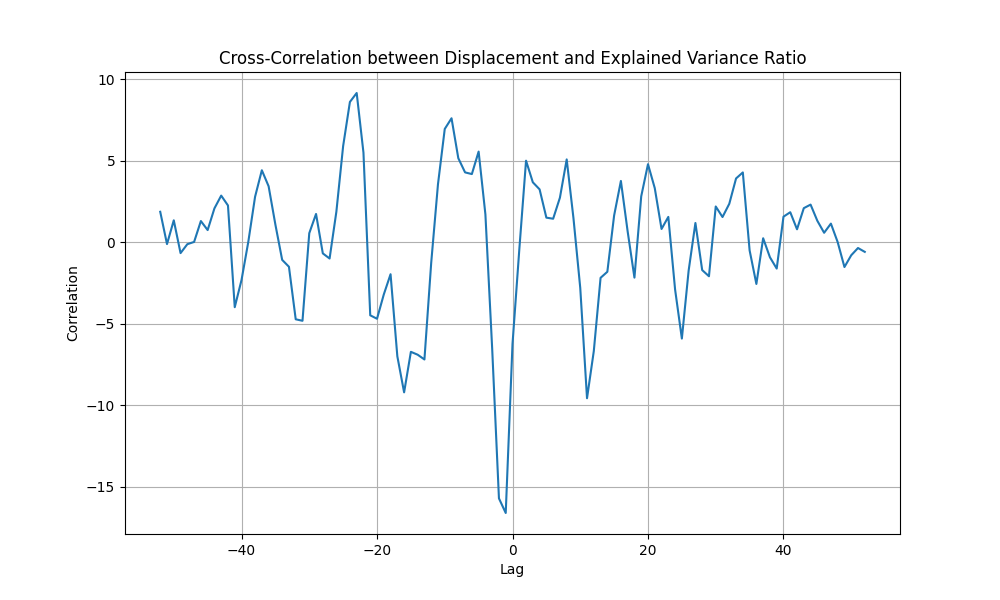

In [24]:
# Assuming 'displacement' and 'first_component_variance_ratio' are numpy arrays or pandas Series
displacement = cell_df['displacement'].values
variance_ratio = first_component_variance_ratio

# Compute cross-correlation
correlation = np.correlate(displacement - np.mean(displacement), variance_ratio - np.mean(variance_ratio), mode='full')
lags = np.arange(-len(displacement) + 1, len(displacement))

# Plot cross-correlation
plt.figure(figsize=(10, 6))
plt.plot(lags, correlation)
plt.title('Cross-Correlation between Displacement and Explained Variance Ratio')
plt.xlabel('Lag')
plt.ylabel('Correlation')
plt.grid(True)
plt.show()


Note that the strong negative correlation at lag -1 suggests that an increase in the variance ratio is associated with a decrease in displacement one frame later. This can be interpreted in the following way: when a cell stretches, it's not moving yet. This is something that we see in videos, and this short lag value is describing that stage of the movement.

#### Lagged Correlation Coefficients
Let's compute the correlation coefficients for different lags to quantify the relationship, but this time bounding the maximum lag to get a more clear picture (since it's effectively to zoom in).

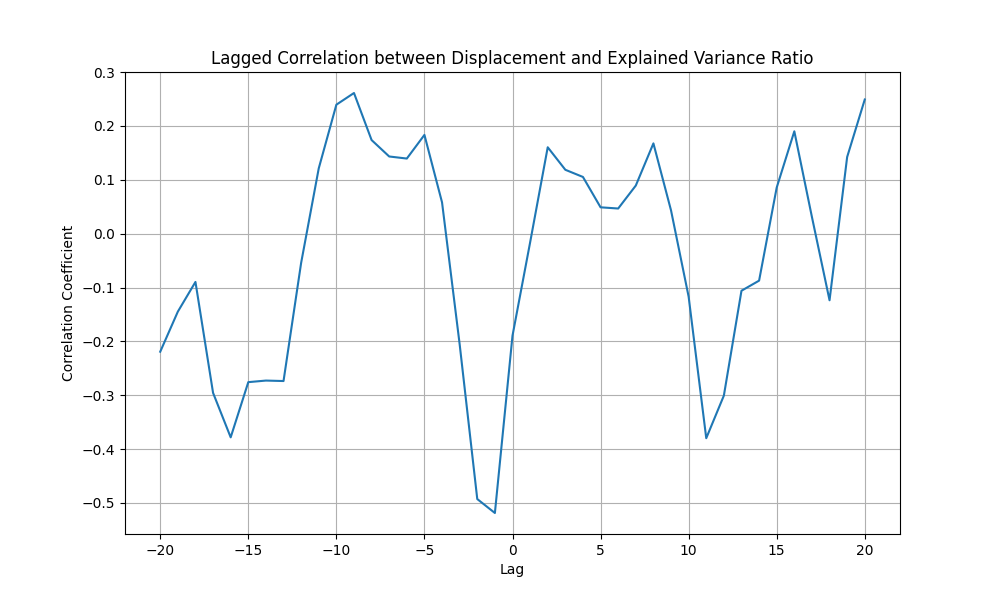

In [27]:
def lagged_correlation(x, y, lag):
    if lag > 0:
        return np.corrcoef(x[:-lag], y[lag:])[0, 1]
    elif lag < 0:
        return np.corrcoef(x[-lag:], y[:lag])[0, 1]
    else:
        return np.corrcoef(x, y)[0, 1]

# Define maximum lag
max_lag = 20  # for example, you can adjust this value

# Compute lagged correlations
lags = np.arange(-max_lag, max_lag + 1)
correlations = [lagged_correlation(variance_ratio, displacement, lag) for lag in lags]
# Note that changing the order of variance_ratio and displacement will change the sign of the lag

# Plot lagged correlations
plt.figure(figsize=(10, 6))
plt.plot(lags, correlations)
plt.title('Lagged Correlation between Displacement and Explained Variance Ratio')
plt.xlabel('Lag')
plt.ylabel('Correlation Coefficient')
plt.grid(True)
plt.show()


Note that changing the order of variance_ratio and displacement will change the sign of the lag

### Granger Causality Test
The Granger causality test can be used to determine if one time series can predict another. This test is based on the principle that if a time series $X$ Granger-causes $Y$, then past values of $X$ should contain information that helps predict $Y$.

In [29]:
from statsmodels.tsa.stattools import grangercausalitytests

# Combine the series into a DataFrame for the test
data = pd.DataFrame({'displacement': displacement, 'variance_ratio': variance_ratio})

# Perform Granger Causality Test
max_lag = 16  # Maximum allowable lag is 16
# Attempting to use a higher value will result in an ValueError due to Insufficient observations

test_result = grangercausalitytests(data[['displacement', 'variance_ratio']], max_lag, verbose=True)

# The test_result will contain p-values and F-statistics for each lag



Granger Causality
number of lags (no zero) 1
ssr based F test:         F=0.2335  , p=0.6311  , df_denom=49, df_num=1
ssr based chi2 test:   chi2=0.2478  , p=0.6186  , df=1
likelihood ratio test: chi2=0.2472  , p=0.6191  , df=1
parameter F test:         F=0.2335  , p=0.6311  , df_denom=49, df_num=1

Granger Causality
number of lags (no zero) 2
ssr based F test:         F=0.7337  , p=0.4857  , df_denom=46, df_num=2
ssr based chi2 test:   chi2=1.6268  , p=0.4433  , df=2
likelihood ratio test: chi2=1.6014  , p=0.4490  , df=2
parameter F test:         F=0.7337  , p=0.4857  , df_denom=46, df_num=2

Granger Causality
number of lags (no zero) 3
ssr based F test:         F=0.1087  , p=0.9545  , df_denom=43, df_num=3
ssr based chi2 test:   chi2=0.3793  , p=0.9445  , df=3
likelihood ratio test: chi2=0.3779  , p=0.9448  , df=3
parameter F test:         F=0.1087  , p=0.9545  , df_denom=43, df_num=3

Granger Causality
number of lags (no zero) 4
ssr based F test:         F=0.1509  , p=0.9615  , df_d

stattools.py (1545): verbose is deprecated since functions should not print results


#### Test results
We are testing if the first principal component's explained variance ratio can predict the displacement. The p-values associated with each test indicate whether the null hypothesis (that the first principal component's explained variance ratio does not Granger-cause the displacement) can be rejected.

- **Low p-value (< 0.05)**: Reject the null hypothesis, indicating that the first principal component's explained variance ratio Granger-causes the displacement.
- **High p-value (≥ 0.05)**: Fail to reject the null hypothesis, indicating no Granger causality.

##### Analysis of results by lag
For each number of lags, we examine the p-values:

1. **1 Lag**:
   - All tests yield high p-values (around 0.63), indicating no significant Granger causality.

2. **2 Lags**:
   - All tests yield high p-values (around 0.48), indicating no significant Granger causality.

3. **3 to 10 Lags**:
   - P-values remain high (well above 0.05), indicating no significant Granger causality.

4. **11 Lags**:
   - SSR based F test: p-value = 0.0361
   - Chi2 test: p-value = 0.0000
   - Likelihood ratio test: p-value = 0.0001
   - Parameter F test: p-value = 0.0361
   - Here, we see significant results indicating that at a lag of 11, the explained variance ratio Granger-causes the displacement.

5. **12 Lags**:
   - SSR based F test: p-value = 0.0310
   - Chi2 test: p-value = 0.0000
   - Likelihood ratio test: p-value = 0.0000
   - Parameter F test: p-value = 0.0310
   - Significant results persist, reinforcing that the explained variance ratio Granger-causes the displacement at a lag of 12.

6. **13 Lags**:
   - Mixed results with chi2 tests showing significant p-values, but parameter F test shows a p-value of 0.0532, slightly above the 0.05 threshold. 

7. **14 to 16 Lags**:
   - For 14 lags, mixed results are observed with significant chi2 p-values but higher F-test p-values.
   - For 15 and 16 lags, significant chi2 test results, but high p-values in parameter F tests, suggest weaker evidence.

##### Summary
- Significant Granger causality is observed at lags 11 and 12. At these lags, the explained variance ratio of the first principal component significantly Granger-causes the displacement.
- For smaller lags, there's no Granger causality.
- For higher lags, we observe significant chi2 p-values, but high F-test p-values (weaker or non-existent evidence), indicating no significant Granger causality.
- This suggests that changes in the explained variance ratio can predict changes in the displacement with a lag of around 11 to 12 frames.

#### Visualization
Let's plot the two signlas together:
1. as given;
2. introducing a lag in the second;
3. idem previous, but only plotting after the lag. 

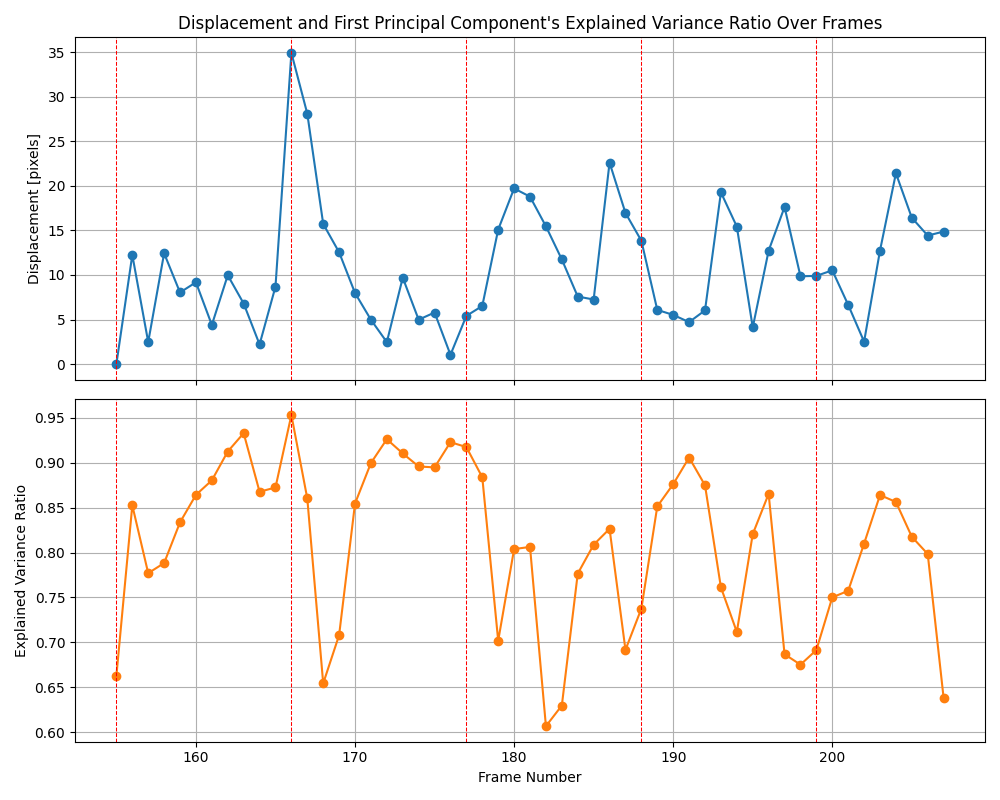

In [33]:
# Create subplots
fig, (ax1, ax2) = plt.subplots(2, 1, sharex=True, figsize=(10, 8))

# Plot Displacement
ax1.plot(cell_df['frame'], cell_df['displacement'], marker='o', linestyle='-', color='tab:blue')
ax1.set_title('Displacement and First Principal Component\'s Explained Variance Ratio Over Frames')
ax1.set_ylabel('Displacement [pixels]')
ax1.grid(True)

# Add vertical dashed lines every 11 frames
for x in range(0, len(cell_df['frame']), 11):
    ax1.axvline(x=cell_df['frame'][x], color='red', linestyle='--', linewidth=0.75)

# Plot First Principal Component's Explained Variance Ratio
ax2.plot(cell_df['frame'], first_component_variance_ratio, marker='o', linestyle='-', color='tab:orange')
ax2.set_xlabel('Frame Number')
ax2.set_ylabel('Explained Variance Ratio')
ax2.grid(True)

# Add vertical dashed lines every 11 frames
for x in range(0, len(cell_df['frame']), 11):
    ax2.axvline(x=cell_df['frame'][x], color='red', linestyle='--', linewidth=0.75)

# Adjust layout to prevent overlap
plt.tight_layout()
plt.show()


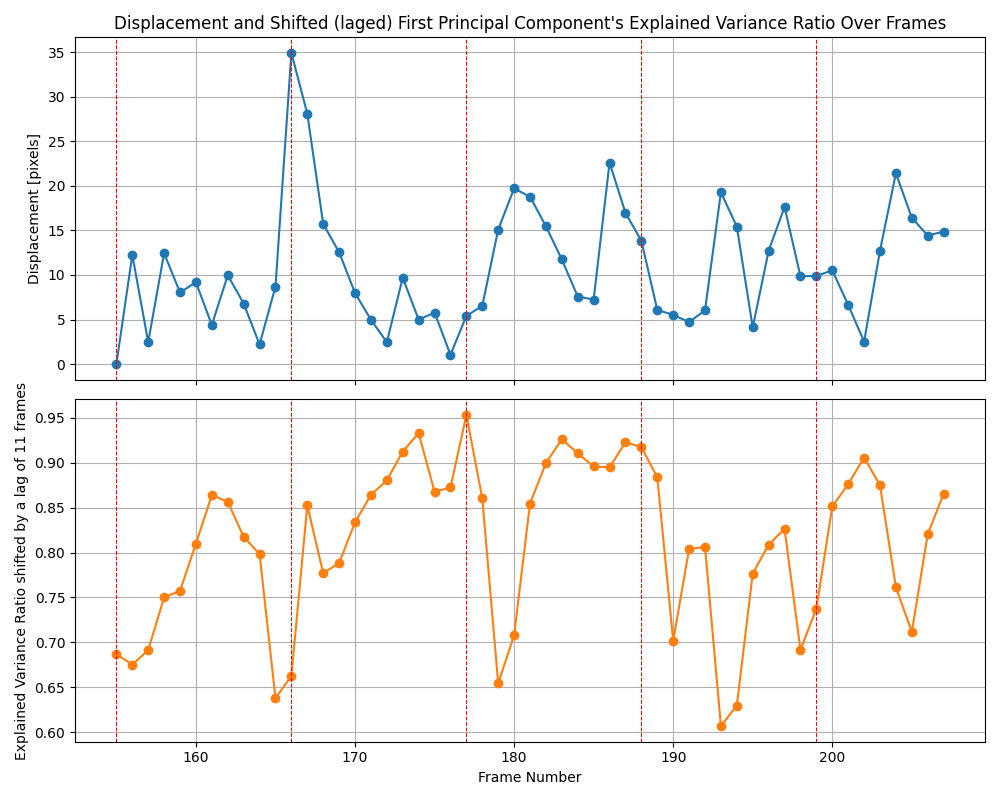

In [67]:
# Create subplots
fig, (ax1, ax2) = plt.subplots(2, 1, sharex=True, figsize=(10, 8))

# Define the lag for shifting the variance ratio
lag = 11
shifted_variance_ratio = np.roll(variance_ratio, lag)

# Plot Displacement
ax1.plot(cell_df['frame'], cell_df['displacement'], marker='o', linestyle='-', color='tab:blue')
ax1.set_title('Displacement and Shifted (laged) First Principal Component\'s Explained Variance Ratio Over Frames')
ax1.set_ylabel('Displacement [pixels]')
ax1.grid(True)

# Add vertical dashed lines every 11 frames
for x in range(0, len(cell_df['frame']), 11):
    ax1.axvline(x=cell_df['frame'][x], color='red', linestyle='--', linewidth=0.75)

# Plot First Principal Component's Explained Variance Ratio
ax2.plot(cell_df['frame'], shifted_variance_ratio, marker='o', linestyle='-', color='tab:orange')
ax2.set_xlabel('Frame Number')
ax2.set_ylabel(f'Explained Variance Ratio shifted by a lag of {lag} frames')
ax2.grid(True)

# Add vertical dashed lines every 11 frames
for x in range(0, len(cell_df['frame']), 11):
    ax2.axvline(x=cell_df['frame'][x], color='red', linestyle='--', linewidth=0.75)

# Adjust layout to prevent overlap
plt.tight_layout()
plt.show()


We have future points before earlier ones due to `np.roll`, let's start the plot after.

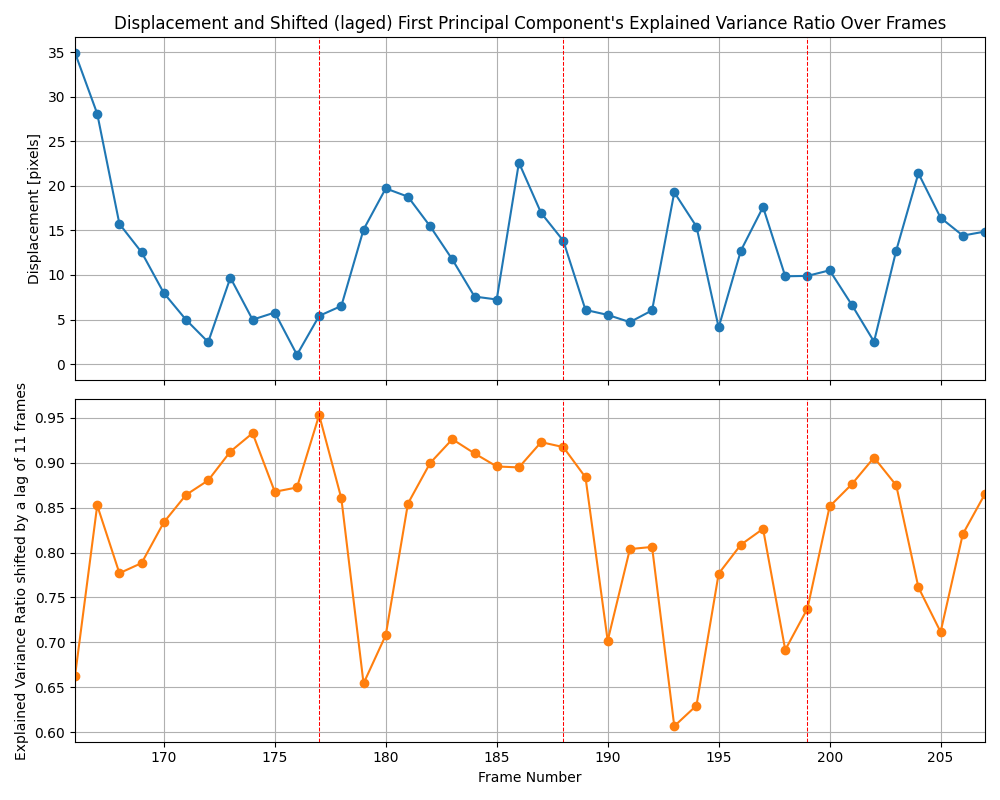

In [69]:
# Create subplots
fig, (ax1, ax2) = plt.subplots(2, 1, sharex=True, figsize=(10, 8))

# Define the lag for shifting the variance ratio
lag = 11
shifted_variance_ratio = np.roll(variance_ratio, lag)

# x-axis limits for the plot
initial_frame_to_plot = cell_df['frame'].iloc[0] + lag
last_frame_to_plot = cell_df['frame'].iloc[-1]

# Plot Displacement
ax1.plot(cell_df['frame'], cell_df['displacement'], marker='o', linestyle='-', color='tab:blue')
ax1.set_title('Displacement and Shifted (laged) First Principal Component\'s Explained Variance Ratio Over Frames')
ax1.set_ylabel('Displacement [pixels]')
ax1.set_xlim(initial_frame_to_plot, last_frame_to_plot)
ax1.grid(True)

# Add vertical dashed lines every 11 frames
for x in range(0, len(cell_df['frame']), 11):
    ax1.axvline(x=cell_df['frame'][x], color='red', linestyle='--', linewidth=0.75)

# Plot First Principal Component's Explained Variance Ratio
ax2.plot(cell_df['frame'], shifted_variance_ratio, marker='o', linestyle='-', color='tab:orange')
ax2.set_xlabel('Frame Number')
ax2.set_ylabel(f'Explained Variance Ratio shifted by a lag of {lag} frames')
ax2.set_xlim(initial_frame_to_plot, last_frame_to_plot)
ax2.grid(True)

# Add vertical dashed lines every 11 frames
for x in range(0, len(cell_df['frame']), 11):
    ax2.axvline(x=cell_df['frame'][x], color='red', linestyle='--', linewidth=0.75)

# Adjust layout to prevent overlap
plt.tight_layout()
plt.show()


### Cross-Correlation with the Signal Processing Module

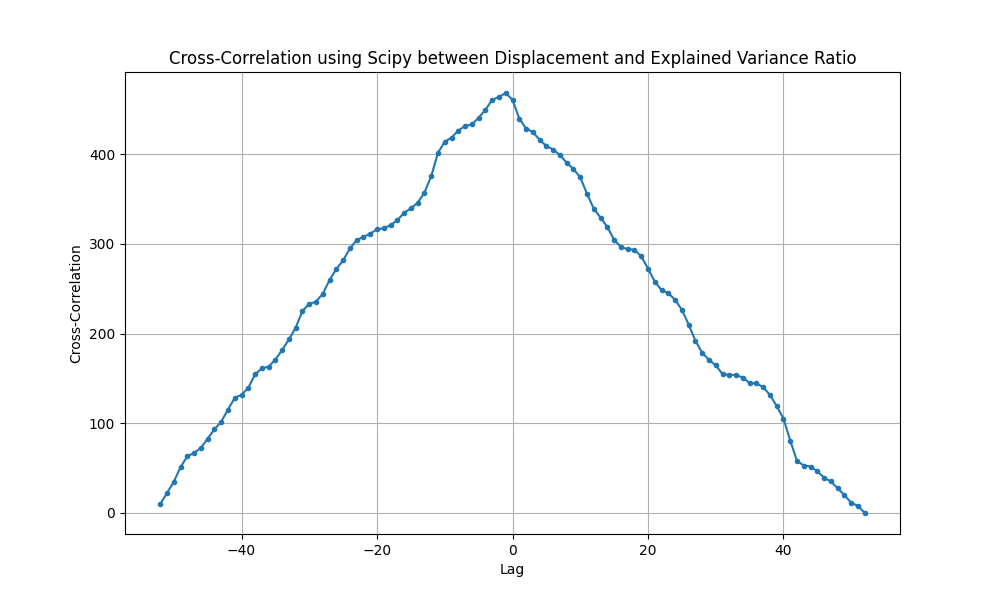

In [57]:
from scipy.signal import correlate

# Cross-correlation using scipy
correlation = correlate(variance_ratio, displacement, mode='full')
lags = np.arange(-len(displacement) + 1, len(displacement))

# Plot the cross-correlation
plt.figure(figsize=(10, 6))
plt.plot(lags, correlation, marker='.', linestyle='-')
plt.title('Cross-Correlation using Scipy between Displacement and Explained Variance Ratio')
plt.xlabel('Lag')
plt.ylabel('Cross-Correlation')
plt.grid(True)
plt.show()


Number of Peaks: 1
First peak at lag -1


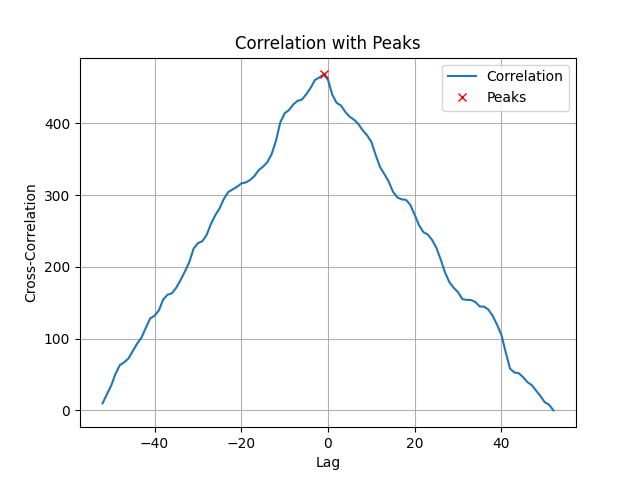

In [58]:
from scipy.signal import find_peaks

# Calculate the peaks in the cross-correlation
peaks, _ = find_peaks(correlation)

# Print the number of peaks
print(f"Number of Peaks: {len(peaks)}")
print(f'First peak at lag {lags[peaks[0]]}')

# Plot displacement with peaks
plt.figure()
plt.plot(lags, correlation, label='Correlation')
plt.plot(lags[peaks], correlation[peaks], 'rx', label='Peaks')
plt.title("Correlation with Peaks")
plt.xlabel("Lag")
plt.ylabel('Cross-Correlation')
plt.legend()
plt.grid()
plt.show()

It only seems to find the peak we found for lag -1. Remember that if you want the peak at 1, you should interchange the order of variance_ratio and displacement in the correlation calculation.